<a href="https://colab.research.google.com/github/HaileyKataram/Qiskit_QPE/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install qiskit qiskit-aer pylatexenc

In [2]:
# Quantum Phase Estimation (QPE) using Qiskit 2.x

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc


In [4]:
def qpe_circuit(num_count_qubits, unitary, theta):
    """
    Constructs the Quantum Phase Estimation (QPE) circuit.
    num_count_qubits: number of counting qubits
    unitary: unitary gate (to apply controlled operations)
    theta: phase parameter (for U gate)
    """
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)

    # Step 1: Apply Hadamard gates on counting qubits
    qc.h(range(num_count_qubits))

    # Step 2: Prepare eigenstate (|1>) for the target qubit
    qc.x(num_count_qubits)

    # Step 3: Apply controlled unitary operations
    for qubit in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)

    # Step 4: Apply inverse QFT to counting qubits
    inverse_qft(qc, num_count_qubits)

    # Step 5: Barrier before measurement (for clarity)
    qc.barrier()

    # Step 6: Measure counting qubits
    qc.measure(range(num_count_qubits), range(num_count_qubits))

    return qc


In [5]:
def run_qpe(num_count_qubits=3, theta=0.125):
    """Executes the QPE circuit and visualizes the phase estimation result."""
    simulator = AerSimulator()
    qc = qpe_circuit(num_count_qubits, "U", theta)

    # Visualize circuit (includes inverse QFT)
    display(qc.draw('mpl'))

    # Compile and simulate
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048).result()
    counts = result.get_counts()

    # Plot histogram
    plot_histogram(counts)
    plt.show()

    # Theoretical expected output
    expected_value = int(theta * (2 ** num_count_qubits))
    expected_binary = format(expected_value, f'0{num_count_qubits}b')
    print(f"\nExpected phase (binary) ≈ {expected_binary}")
    print(qc.draw(output='text'))


In [6]:
def run_qpe_with_noise(num_count_qubits=3, theta=0.125):
    """Executes the QPE circuit under noisy conditions."""
    simulator = AerSimulator()

    # Define depolarizing noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['h', 'x'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cp', 'swap'])

    qc = qpe_circuit(num_count_qubits, "U", theta)

    # Visualize noisy circuit
    display(qc.draw('mpl'))

    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048, noise_model=noise_model).result()
    counts = result.get_counts()

    # Plot noisy histogram
    plot_histogram(counts)
    plt.show()

    expected_value = int(theta * (2 ** num_count_qubits))
    expected_binary = format(expected_value, f'0{num_count_qubits}b')
    print(f"\nExpected phase (binary) ≈ {expected_binary} (with noise)")
    print("Note: Noise reduces accuracy, histogram may be spread out.")



🔸 Running QPE with θ = 0.125


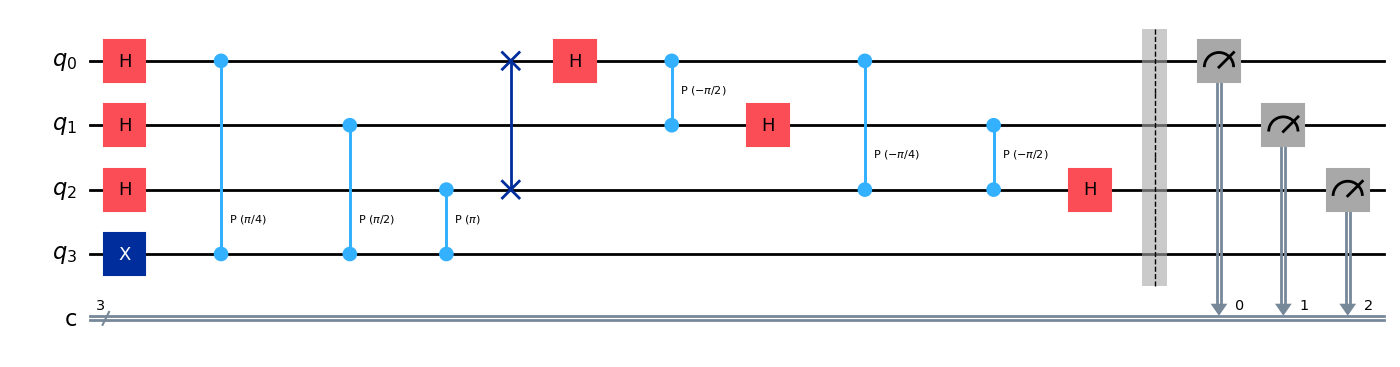


Expected phase (binary) ≈ 001
     ┌───┐                            ┌───┐                                   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                            »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«           ░ ┌─┐      
«q_0: ──────░─┤M├──────
«           ░ └╥┘┌─┐   
«q_1: ──────░──╫─

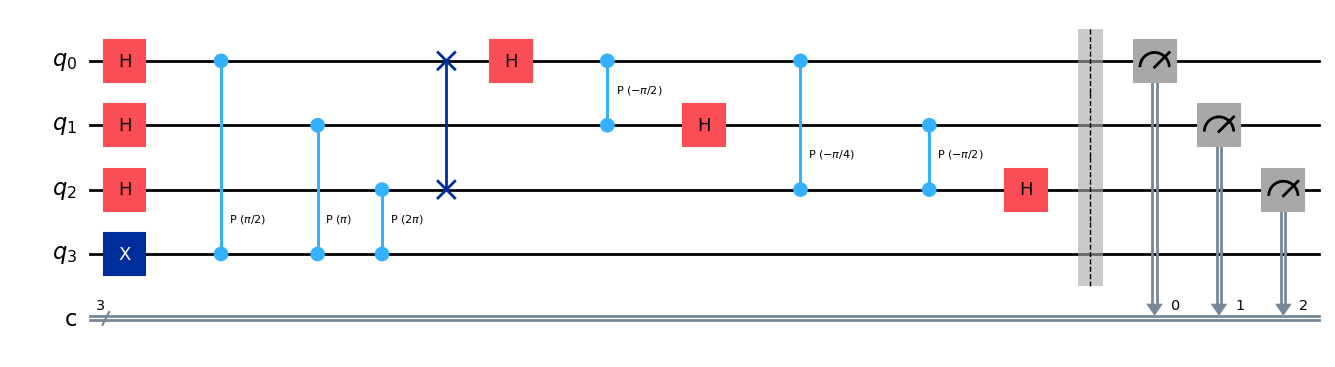


Expected phase (binary) ≈ 010
     ┌───┐                           ┌───┐                                   »
q_0: ┤ H ├─■───────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                       │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■──────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │              │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼──────■───────X──────────────────────■─────────■────────»
     ├───┤ │P(π/2)  │P(π)  │P(2π)                                            »
q_3: ┤ X ├─■────────■──────■─────────────────────────────────────────────────»
     └───┘                                                                   »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«           ░ ┌─┐      
«q_0: ──────░─┤M├──────
«           ░ └╥┘┌─┐   
«q_1: ──────░──╫─┤M├───
«   

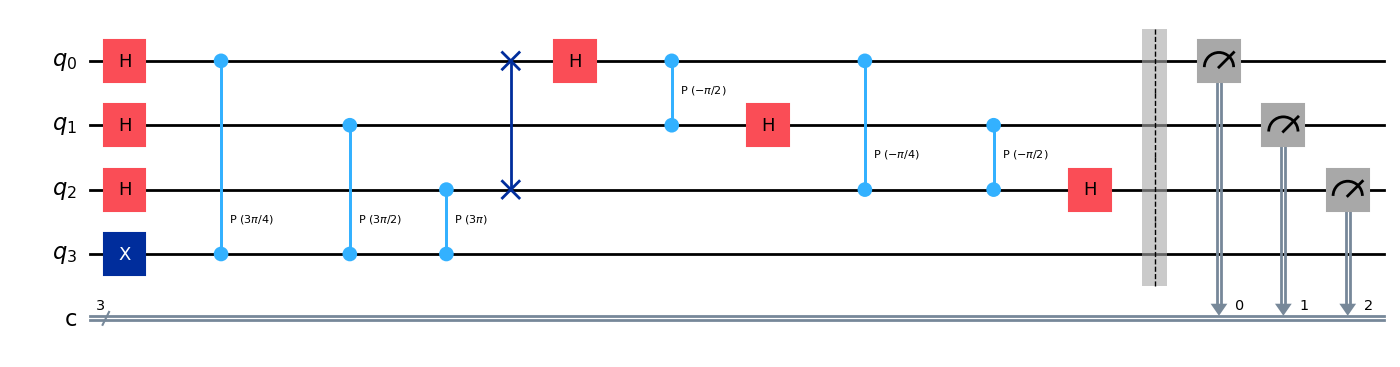


Expected phase (binary) ≈ 011
     ┌───┐                               ┌───┐                         »
q_0: ┤ H ├─■───────────────────────────X─┤ H ├─■──────────────■────────»
     ├───┤ │                           │ └───┘ │P(-π/2) ┌───┐ │        »
q_1: ┤ H ├─┼─────────■─────────────────┼───────■────────┤ H ├─┼────────»
     ├───┤ │         │                 │                └───┘ │P(-π/4) »
q_2: ┤ H ├─┼─────────┼─────────■───────X──────────────────────■────────»
     ├───┤ │P(3π/4)  │P(3π/2)  │P(3π)                                  »
q_3: ┤ X ├─■─────────■─────────■───────────────────────────────────────»
     └───┘                                                             »
c: 3/══════════════════════════════════════════════════════════════════»
                                                                       »
«                     ░ ┌─┐      
«q_0: ────────────────░─┤M├──────
«                     ░ └╥┘┌─┐   
«q_1: ─■──────────────░──╫─┤M├───
«      │P(-π/2) ┌───┐ ░  ║ └╥┘

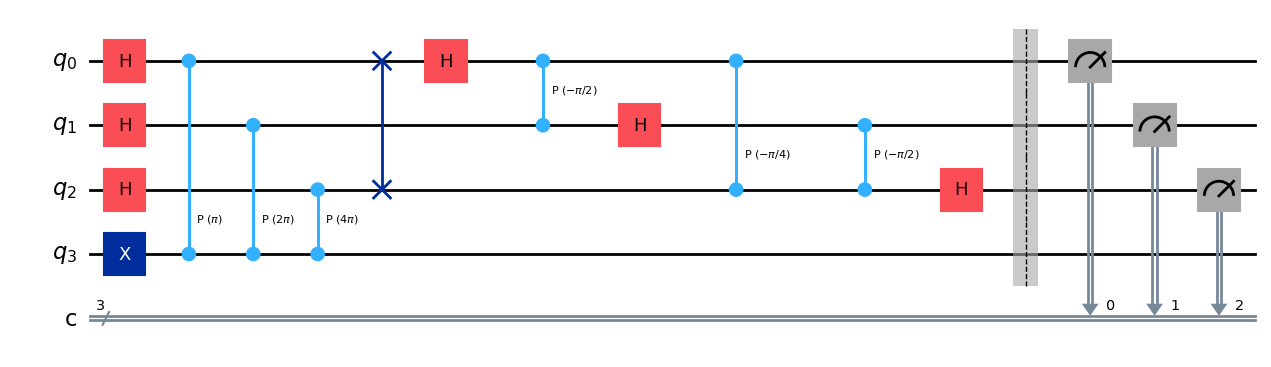


Expected phase (binary) ≈ 100
     ┌───┐                          ┌───┐                                   »
q_0: ┤ H ├─■──────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                      │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼──────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │      │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼──────┼───────■───────X──────────────────────■─────────■────────»
     ├───┤ │P(π)  │P(2π)  │P(4π)                                            »
q_3: ┤ X ├─■──────■───────■─────────────────────────────────────────────────»
     └───┘                                                                  »
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«           ░ ┌─┐      
«q_0: ──────░─┤M├──────
«           ░ └╥┘┌─┐   
«q_1: ──────░──╫─┤M├───
«     ┌───┐ ░  

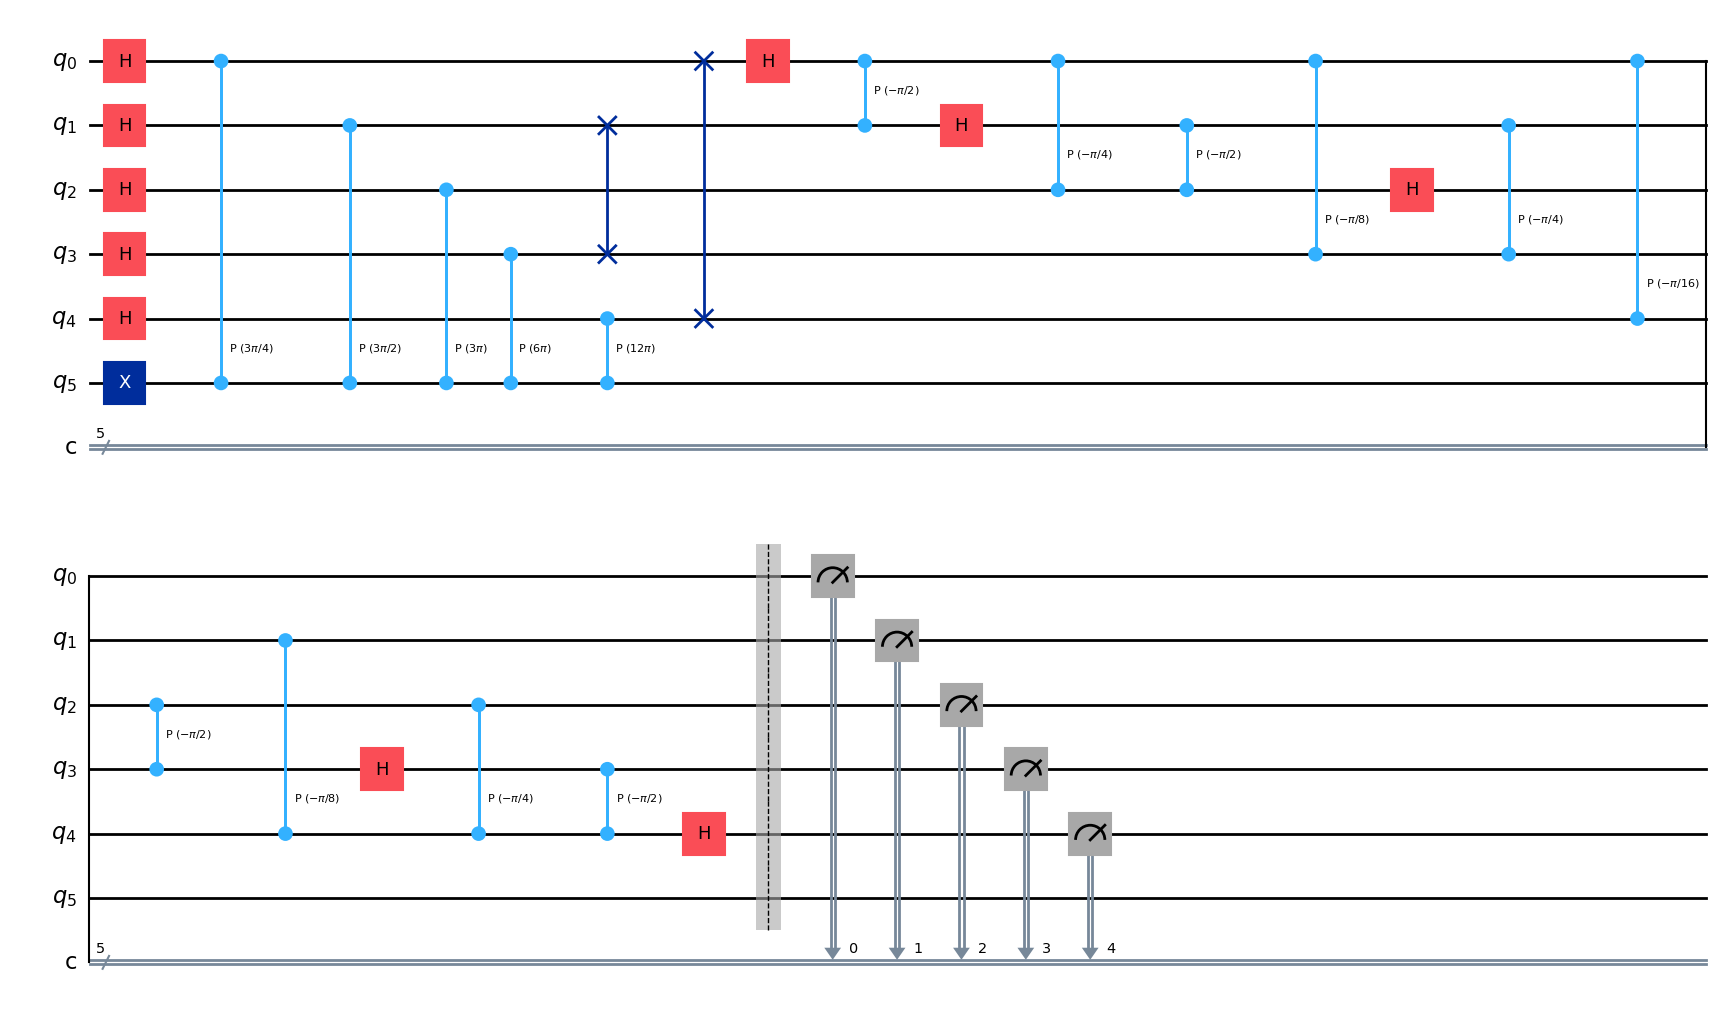


Expected phase (binary) ≈ 01100
     ┌───┐                                                ┌───┐               »
q_0: ┤ H ├─■────────────────────────────────────────────X─┤ H ├─■─────────────»
     ├───┤ │                                            │ └───┘ │P(-π/2) ┌───┐»
q_1: ┤ H ├─┼─────────■────────────────────────────X─────┼───────■────────┤ H ├»
     ├───┤ │         │                            │     │                └───┘»
q_2: ┤ H ├─┼─────────┼─────────■──────────────────┼─────┼─────────────────────»
     ├───┤ │         │         │                  │     │                     »
q_3: ┤ H ├─┼─────────┼─────────┼───────■──────────X─────┼─────────────────────»
     ├───┤ │         │         │       │                │                     »
q_4: ┤ H ├─┼─────────┼─────────┼───────┼───────■────────X─────────────────────»
     ├───┤ │P(3π/4)  │P(3π/2)  │P(3π)  │P(6π)  │P(12π)                        »
q_5: ┤ X ├─■─────────■─────────■───────■───────■──────────────────────────────»
     └─

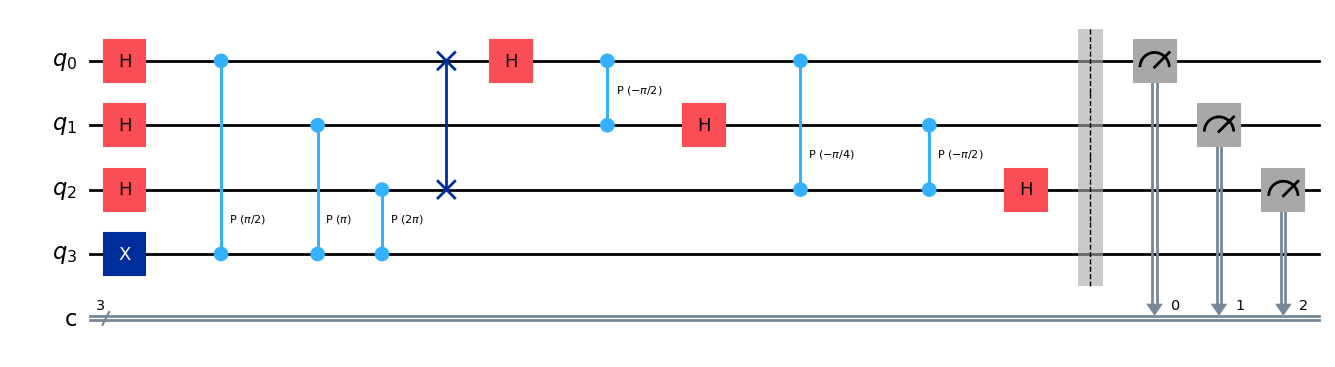


Expected phase (binary) ≈ 010 (with noise)
Note: Noise reduces accuracy, histogram may be spread out.


In [7]:
if __name__ == "__main__":
    # 🔹 1. Change Phase Values
    for theta in [0.125, 0.25, 0.375, 0.5]:
        print(f"\n🔸 Running QPE with θ = {theta}")
        run_qpe(num_count_qubits=3, theta=theta)

    # 🔹 2. Higher Precision
    print("\n🔸 Running QPE with 5 counting qubits (higher precision)...")
    run_qpe(num_count_qubits=5, theta=0.375)

    # 🔹 3. Noise Simulation
    print("\n🔸 Running QPE with Noise Simulation (θ = 0.25)...")
    run_qpe_with_noise(num_count_qubits=3, theta=0.25)
